In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split, KFold

%matplotlib inline
plt.style.use('seaborn-white')

# Problem Set 3

## Exercise 1

DGP:

* 2 classes; each classes n observations
* 2 covariates: $X_1 \sim \mathscr{N} (\mu_1, \Sigma_1)$ and $X_2 \sim \mathscr{N} (\mu_2, \Sigma_2)$
* $\mu_1 = (-3, 3)$ for class 1, $\mu_2 = (5, 5)$ for class 2, $\Sigma_1=\Sigma_2=\Sigma=
\left[ \begin{array}{ccc}
16 & -2\\
-2 & 9
\end{array} 
\right ]$
* $n_1=300$, $n_2=500$

Use the general procedure for generating the dataframe and for calculating the lda
and the qda function from exercise 1 in the last problem set.

Questions:

**a)** Calculate the mean training error and the mean test error using a new data set with the same specifications
as the training data for both methods and compare the results.

In [2]:
np.random.seed(100)

In [3]:
sigma = np.array([[16, -2], [-2, 9]])

# First redefine the functions we have used in the last problem set.
def generate_data_ex1(cov1, cov2):
    """
    """
    n_11 = 300
    n_12 = 500
    n_21 = 300
    n_22 = 500

    mu_1 = np.array([-3, 3])
    mu_2 = np.array([5, 5])   

    y_1 = np.zeros(n_11 + n_12)
    y_2 = np.ones(n_21 + n_22)

    x_1 = np.random.multivariate_normal(mu_1, cov1, n_11 + n_12)
    x_2 = np.random.multivariate_normal(mu_2, cov2, n_21 + n_22)

    X = np.concatenate((x_1, x_2), axis=0)
    y = np.concatenate((y_1, y_2))
    
    return X, y

In [4]:
# Reconduct the training error analysis for both methods.
data_x, data_y = generate_data_ex1(sigma, sigma)

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred_linear = lda.fit(data_x, data_y).predict(data_x)

qda = QuadraticDiscriminantAnalysis()
y_pred_quad = qda.fit(data_x, data_y).predict(data_x)

lda_mean_error = np.mean(data_y != y_pred_linear)
qda_mean_error = np.mean(data_y != y_pred_quad)

print('LDA training mean error: {}\nQDA training mean error: {}'.format(lda_mean_error, qda_mean_error))

LDA training mean error: 0.131875
QDA training mean error: 0.133125


In [5]:
# Generate a test dataset.
test_x, test_y = generate_data_ex1(sigma, sigma)

# Calculate mean test error for both errors.
y_tpred_linear = lda.fit(data_x, data_y).predict(test_x)
y_tpred_quad = qda.fit(data_x, data_y).predict(test_x)

lda_mean_terror = np.mean(test_y != y_tpred_linear)
qda_mean_terror = np.mean(test_y != y_tpred_quad)

print('LDA mean test error: {}\nQDA mean test error: {}'.format(lda_mean_terror, qda_mean_terror))

LDA mean test error: 0.15
QDA mean test error: 0.150625


**b)** Write a function that uses the validation set approach for generating test and training sample.

In [6]:
def validation_set(size, data_X, data_Y, **kwargs):
    """
    This is the function designed for validation set approach.
    Input:
        size (float): A number between ]0, 1[ representing the proportion of spliting.
        data_X (np.ndarray): Predictors.
        data_Y (np.1darray): Responses.
        **kwargs:
            random_states (int): The seed used by the random number generator. Default 1.
            method: Estimation method. In this situation default is 
                    LinearDiscriminantAnalysis(solver='svd')
    Output:
        train_X, train_Y, test_X, test_Y (np.ndarray): Training sample and test sample.
        z(np.1darray): Array of mean error rate.
    """
    random_states = kwargs.get('random_states', 1)
    method = kwargs.get('method', LinearDiscriminantAnalysis(solver='svd'))
    
    # Set random states.
    r_state = np.arange(0, random_states)    
    
    # Generate 10 random splits of the dataset and do the LDA fit.    
    z=[]
    train_X = []
    train_Y = []
    test_X = []
    test_Y = []
    for r in r_state:
        #poly = PolynomialFeatures(x[i, j])
        #x_poly = poly.fit_transform(data_X)

        x_train, x_test, y_train, y_test = train_test_split(
            data_X, data_Y, test_size=size,
            random_state = r
        )  # The way of setting the random_state is to gurantee that 
           # we have 10 times different random draws.
        train_X.append(x_train)
        train_Y.append(y_train)
        test_X.append(x_test)
        test_Y.append(y_test)

        # Test error rate.
        y_pred = method.fit(x_train, y_train).predict(x_test)
        z.append(np.mean(y_pred != y_test))
        #z.append(1 - accuracy_score(y_test, y_pred))
        
    z = np.array(z)
    train_X = np.array(train_X)
    train_Y = np.array(train_Y)
    test_X = np.array(test_X)
    test_Y = np.array(test_Y)
        
    return train_X, train_Y, test_X, test_Y, z

In [7]:
# Have a look on the validation_set result.
tnx, tny, ttx, tty, err = validation_set(0.5, data_x, data_y)
err.mean()

0.14625

**Remark:** Actually the error rate of validation set approach should be one single float. However, considering the very unstable property of this method, you can repeat the split for $m$ different times  by setting `random_states=m` and calculate the mean value of those errors. Here by default, `random_states=1` 

**c)** Write a function that performs k-fold cross-validation for generating test and training sample.

In [8]:
def k_fold(folds, data_X, data_Y, **kwargs):
    """
    This is the function designed for validation set approach.
    Input:
        folds (int): How many folds for spliting data?
        data_X (np.ndarray): Predictors.
        data_Y (np.1darray): Responses.
        **kwargs:
            random_states (int): The seed used by the random number generator. Default 1.
            method: Estimation method. In this situation default is 
                    LinearDiscriminantAnalysis(solver='svd')
            score_method: How to evaluate the mean error rate: for this classification
                        situation, default is set to accuracy_score.
    Output:
        train_X_r, train_Y_r, test_X_r, test_Y_r (np.ndarray): 4d array;training sample and test sample.
        z(np.1darray): Array of mean error rate.
    """
    random_states = kwargs.get('random_states', 1)
    method = kwargs.get('method', LinearDiscriminantAnalysis(solver='svd'))
    #score_method = kwargs.get('score_method', accuracy_score)
    # Set random states.
    r_state = np.arange(0, random_states)    
    
    # Generate folds random splits of the dataset for r_state times and do the LDA fit.    
    k_err=[]
    train_X_r = []
    train_Y_r = []
    test_X_r = []
    test_Y_r = []
    for r in r_state:
        z=[]
        train_X = []
        train_Y = []
        test_X = []
        test_Y = []
        kf = KFold(n_splits=folds, random_state=r, shuffle=True)
        for train_index, test_index in kf.split(data_X):
            x_train, x_test = data_X[train_index], data_X[test_index]
            y_train, y_test = data_Y[train_index], data_Y[test_index]           
            
            # Appending to the list.
            train_X.append(x_train)
            train_Y.append(y_train)
            test_X.append(x_test)
            test_Y.append(y_test)
            
            # Test error rate.
            y_pred = method.fit(x_train, y_train).predict(x_test)
            z.append(np.mean(y_pred != y_test))
        
        
        z = np.array(z)
        train_X = np.array(train_X)
        train_Y = np.array(train_Y)
        test_X = np.array(test_X)
        test_Y = np.array(test_Y)
    
    k_err.append(z)
    train_X_r.append(train_X)
    train_Y_r.append(train_Y)
    test_X_r.append(test_X)
    test_Y_r.append(test_Y)
    
    k_err = np.array(k_err)
    train_X_r = np.array(train_X_r)
    train_Y_r = np.array(train_Y_r)
    test_X_r = np.array(test_X_r)
    test_Y_r = np.array(test_Y_r)    
    
        
    return train_X_r, train_Y_r, test_X_r, test_Y_r, k_err

In [9]:
# Have a look on k_fold function's results (an array with k mean errors).
kf_tnx, kf_tny, kf_ttx, kf_tty, kf_err = k_fold(10, data_x, data_y)
kf_err

array([[0.11875, 0.18125, 0.125  , 0.18125, 0.13125, 0.11875, 0.11875,
        0.08125, 0.175  , 0.09375]])

## Exercise 2

Evaluate the difference between the lda and qda methods through calculating classification training and test
error for 100 different simulation runs. For each run, compare the difference between the

**a)** validation set approach

**b)** 5-fold cross-validation

**c)** 10-fold cross-validation

From the theoretical properties discussed in the lecture, propose a suitable metric for comparing these three
methods and compare the results of your simulation study with your expectations.

Text(0.5, 1.0, 'Comparisions In Test Errors Among Different Methods')

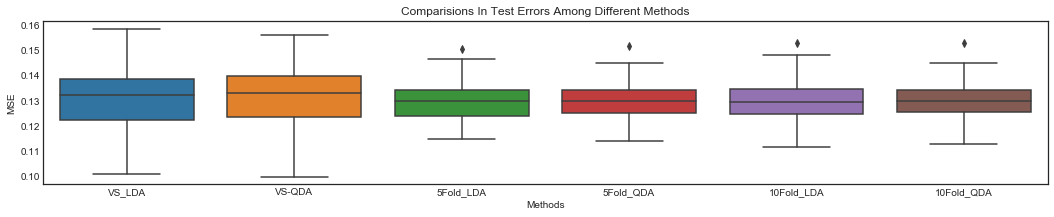

In [10]:
# We give an example of test error rate.
sim = 100

mr_vsa_lda = []
mr_f5_lda = []
mr_f10_lda = []

mr_vsa_qda = []
mr_f5_qda = []
mr_f10_qda = []

for _ in range(sim):   
    data_x, data_y = generate_data_ex1(sigma, sigma)
    
    # LDA.
    vsa_err_lda = validation_set(0.5, data_x, data_y, random_states=1)[4]
    k5_err_lda = k_fold(5, data_x, data_y)[4]
    k10_err_lda = k_fold(10, data_x, data_y)[4]
    
            
    mr_vsa_lda.append(vsa_err_lda.mean())
    mr_f5_lda.append(k5_err_lda.mean())
    mr_f10_lda.append(k10_err_lda.mean())
    
    #QDA.
    vsa_err_qda = validation_set(0.5, data_x, data_y, random_states=1, 
                                 method=QuadraticDiscriminantAnalysis())[4]
    k5_err_qda = k_fold(5, data_x, data_y,
                       method=QuadraticDiscriminantAnalysis())[4]
    k10_err_qda = k_fold(10, data_x, data_y,
                        method=QuadraticDiscriminantAnalysis())[4]    
    
    mr_vsa_qda.append(vsa_err_qda.mean())
    mr_f5_qda.append(k5_err_qda.mean())
    mr_f10_qda.append(k10_err_qda.mean())

mr_vsa_lda = np.array(mr_vsa_lda).reshape(-1,1)
mr_f5_lda = np.array(mr_f5_lda).reshape(-1, 1)
mr_f10_lda = np.array(mr_f10_lda).reshape(-1,1)

mr_vsa_qda = np.array(mr_vsa_qda).reshape(-1,1)
mr_f5_qda = np.array(mr_f5_qda).reshape(-1, 1)
mr_f10_qda = np.array(mr_f10_qda).reshape(-1,1)

mr_comb = np.concatenate((mr_vsa_lda, mr_vsa_qda, 
                          mr_f5_lda, mr_f5_qda, 
                          mr_f10_lda, mr_f10_qda), axis=1)

df_comb = pd.DataFrame(mr_comb, columns=['VS_LDA', 'VS-QDA',
                                         '5Fold_LDA', '5Fold_QDA',
                                         '10Fold_LDA', '10Fold_QDA'])

# Create the long dataframe to prepare for the plot.
df_comb_long = pd.melt(df_comb, var_name='Methods', value_name='MSE')

# Boxplot.
fig1, ax1 = plt.subplots(figsize=(18, 3))

sns.boxplot(x='Methods', y = 'MSE', data=df_comb_long, orient='v', ax=ax1)
ax1.set_title('Comparisions In Test Errors Among Different Methods')